In [1]:
# notebooks/eda.ipynb

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [4]:
# Load datasets
DATA_PATH = "../data/raw"

files = {
    "gdp_per_capita": "gdp_per_capita_worldbank.csv",
    "inflation": "inflation_worldbank.csv",
    "unemployment": "unemployment_worldbank.csv",
    "population": "population_worldbank.csv",
    "gini_index": "gini_index_worldbank.csv",
    "education_spending_gdp": "education_spending_gdp_worldbank.csv"
}

dfs = {}
for name, filename in files.items():
    df = pd.read_csv(os.path.join(DATA_PATH, filename))
    df["date"] = pd.to_numeric(df["date"], errors="coerce")
    df = df.dropna(subset=["value"])
    df = df.rename(columns={"value": name})
    dfs[name] = df[["country", "country_code", "date", name]]

In [5]:

# Merge all indicators by country and year
from functools import reduce
merged_df = reduce(
    lambda left, right: pd.merge(left, right, on=["country", "country_code", "date"], how="outer"),
    dfs.values()
)

# Check for missing data
missing_by_indicator = merged_df.isnull().mean().sort_values()
print("Percentage of missing values per variable:")
print(missing_by_indicator)

# Check data completeness by country
completitud = merged_df.groupby("country")\
    .apply(lambda x: x.notnull().mean())\
    .sort_values("gdp_per_capita", ascending=False)



Percentage of missing values per variable:
country                   0.000000
country_code              0.000000
date                      0.000000
gdp_per_capita            0.000000
inflation                 0.000000
unemployment              0.000000
population                0.000000
education_spending_gdp    0.117647
gini_index                0.252101
dtype: float64


/var/folders/zf/wj_jktvx4jb2w0ylv97cdxyh0000gn/T/ipykernel_22394/887431078.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.notnull().mean())\


In [6]:

# Display country-level completeness with visual formatting
completitud = merged_df.groupby("country")\
    .apply(lambda x: x.notnull().mean())\
    .sort_values("gdp_per_capita", ascending=False)

completitud.style.background_gradient(cmap="YlGnBu").format("{:.1%}")

/var/folders/zf/wj_jktvx4jb2w0ylv97cdxyh0000gn/T/ipykernel_22394/3699661778.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.notnull().mean())\


,country,country_code,date,gdp_per_capita,inflation,unemployment,population,gini_index,education_spending_gdp
country,,,,,,,,,
China,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,66.7%,85.7%
Norway,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,95.2%,95.2%
United Kingdom,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,90.5%,95.2%
Sweden,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,95.2%,90.5%
Spain,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,95.2%,95.2%
Singapore,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,0.0%,100.0%
Portugal,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,95.2%,90.5%
Poland,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,95.2%,90.5%
Netherlands,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,85.7%,95.2%


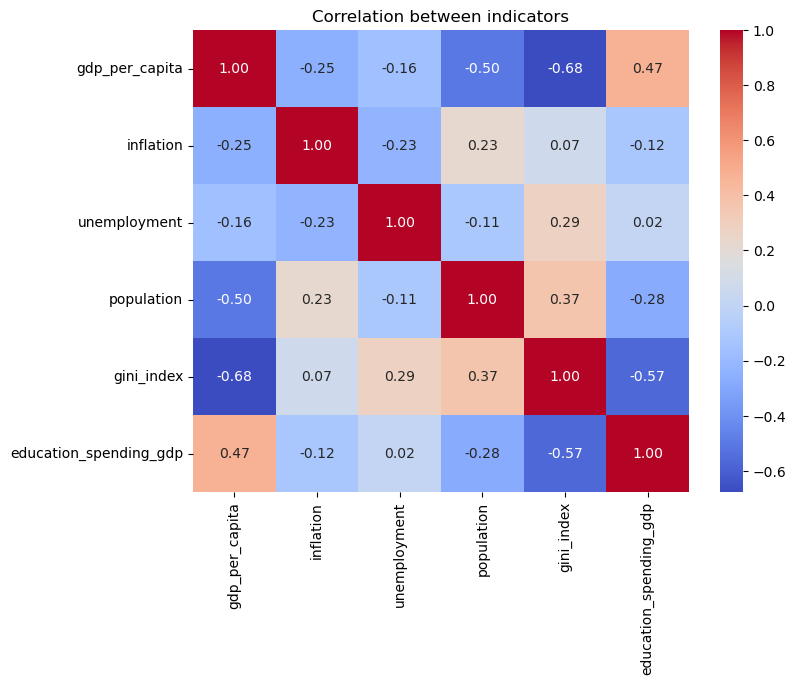

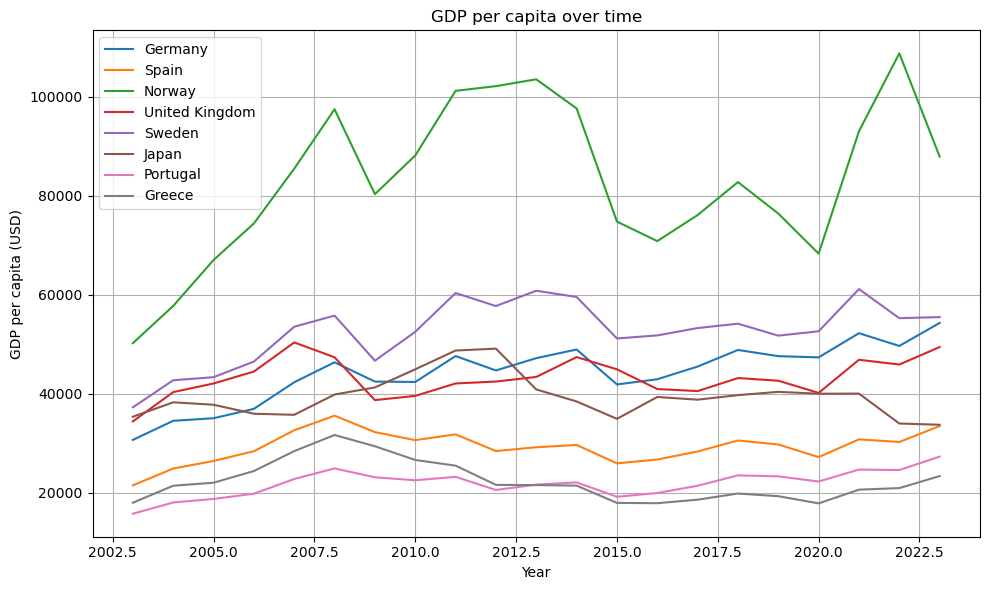

In [7]:
# EDA: correlation between indicators
corr = merged_df.drop(columns=["country", "country_code", "date"]).corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between indicators")
plt.show()

# Temporal evolution of GDP per capita (selected countries only)
selected_countries = ["Germany", "Spain", "Norway", "United Kingdom","Sweden", "Japan", "Portugal", "Greece"]

plt.figure(figsize=(10, 6))
for country in selected_countries:
    subset = merged_df[(merged_df["country"] == country)]
    plt.plot(subset["date"], subset["gdp_per_capita"], label=country)

plt.xlabel("Year")
plt.ylabel("GDP per capita (USD)")
plt.title("GDP per capita over time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 🧠 Exploratory Data Analysis – Key Insights

In this phase, a preliminary cleaning and analysis of macroeconomic indicators was conducted for 18 countries across Europe and Asia. The main findings are:

* **Data quality:** Most key indicators (GDP per capita, inflation, unemployment, and population) are 100% available for all countries. The most incomplete variables are the Gini index and education spending as a percentage of GDP.
  
* **Relevant correlations:**
  * There is a strong negative correlation between GDP per capita and income inequality (Gini index), suggesting that wealthier countries tend to have more equitable income distribution.
  * A positive relationship is also observed between investment in education and lower inequality, reinforcing the structural role of education in economic development.
  
* **Countries with better data coverage:** China, the United Kingdom, Spain, the Netherlands, France, Germany, Sweden, and Norway. These will be considered key candidates for further comparative analysis.

In [8]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.path.dirname("__file__"), ".."))
sys.path.append(project_root)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from functools import reduce
from src.preprocessing import load_and_clean_indicator, aggregate_historical

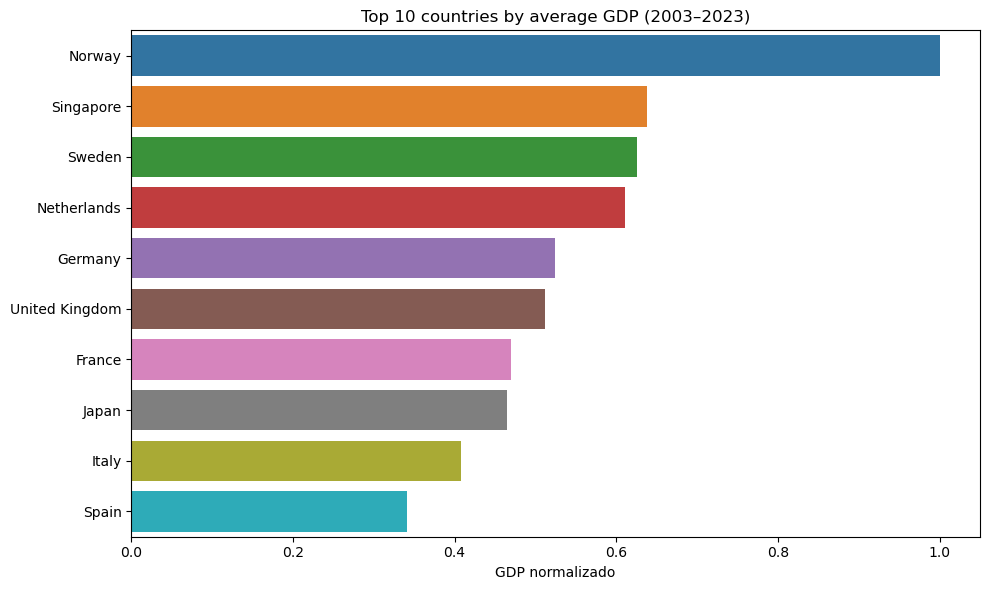

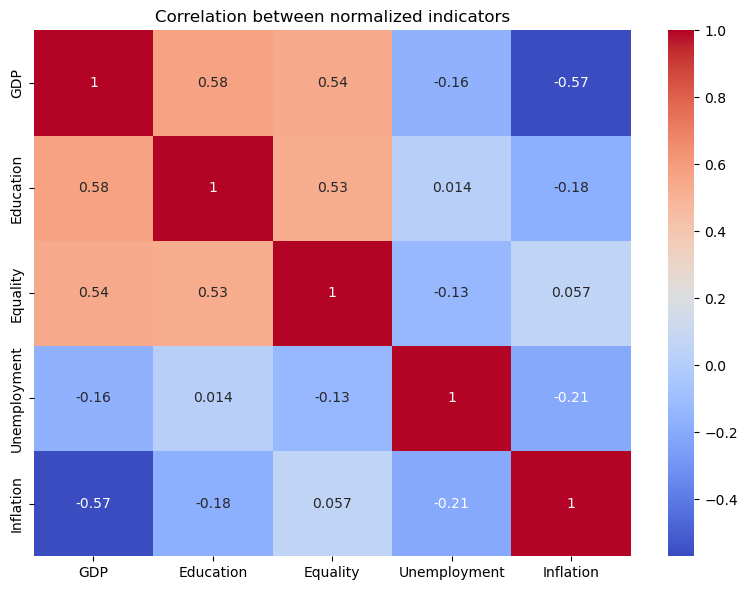

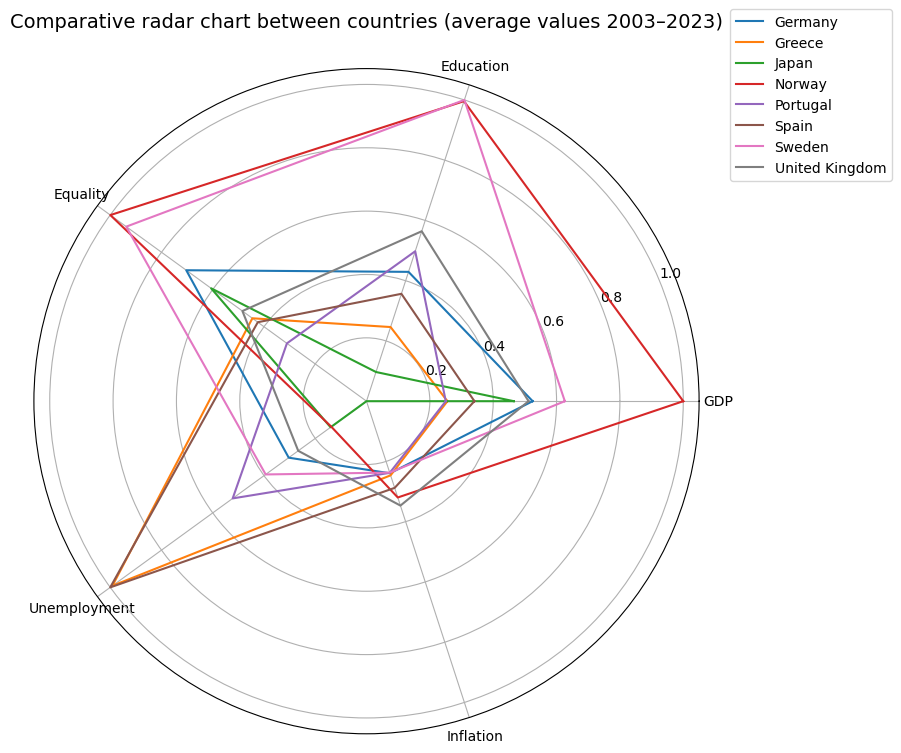

In [9]:
data_path = "../data/raw/"

# Indicators to compare
indicators = [
    "gdp_per_capita",
    "inflation",
    "unemployment",
    "gini_index",
    "education_spending_gdp"
]
dfs = []

# Load and clean all indicators
for ind in indicators:
    df = load_and_clean_indicator(f"{data_path}{ind}_worldbank.csv", ind)
    dfs.append(df)

# Merge + historical average
df_avg = aggregate_historical(dfs)

# Invert Gini so that "more equality = higher score"
df_avg["gini_index_inverted"] = 1 - MinMaxScaler().fit_transform(df_avg[["gini_index"]])

# Normalize remaining variables
scaler = MinMaxScaler()
columns_to_scale = [
    "gdp_per_capita",
    "inflation",
    "unemployment",
    "education_spending_gdp"
]
df_avg[columns_to_scale] = scaler.fit_transform(df_avg[columns_to_scale])

# Prepare data for visualization
plot_df = df_avg[[
    "country", "gdp_per_capita", "education_spending_gdp",
    "gini_index_inverted", "unemployment", "inflation"
]].copy()

# Rename columns for readability
plot_df = plot_df.rename(columns={
    "gdp_per_capita": "GDP",
    "education_spending_gdp": "Education",
    "gini_index_inverted": "Equality",
    "unemployment": "Unemployment",
    "inflation": "Inflation"
})

# Barplot: top 10 countries by average GDP
top_gdp = plot_df.sort_values(by="GDP", ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(data=top_gdp, x="GDP", y="country", hue="country", dodge=False, legend=False)
plt.title("Top 10 countries by average GDP (2003–2023)")
plt.xlabel("GDP normalizado")
plt.ylabel("")
plt.tight_layout()
plt.show()

# Heatmap of correlation between indicators
plt.figure(figsize=(8, 6))
sns.heatmap(plot_df.drop(columns="country").corr(), annot=True, cmap="coolwarm")
plt.title("Correlation between normalized indicators")
plt.tight_layout()
plt.show()

# Comparative radar chart between countries (normalized historical averages)
selected_countries = ["Germany", "Spain", "Norway", "United Kingdom", "Sweden", "Japan", "Portugal", "Greece"]
radar_data = plot_df[plot_df["country"].isin(selected_countries)].set_index("country")

labels = radar_data.columns.tolist()
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(9, 10))
for country, row in radar_data.iterrows():
    values = row.tolist()
    values += values[:1]
    plt.polar(angles, values, label=country)

plt.xticks(angles[:-1], labels, fontsize=10)
plt.title("Comparative radar chart between countries (average values 2003–2023)", size=14, y=1.05)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()

In [10]:
context_data = {
    "country": [
        "Germany", "Spain", "Norway", "United Kingdom",
        "Sweden", "Japan", "Portugal", "Greece"
    ],
    # Scale from 1 (very low) to 5 (very high)
    "lgbt_score":      [4, 5, 5, 5, 5, 2, 4, 3],
    "maternity_score": [4, 4, 5, 3, 5, 2, 4, 3]
}

context_df = pd.DataFrame(context_data)

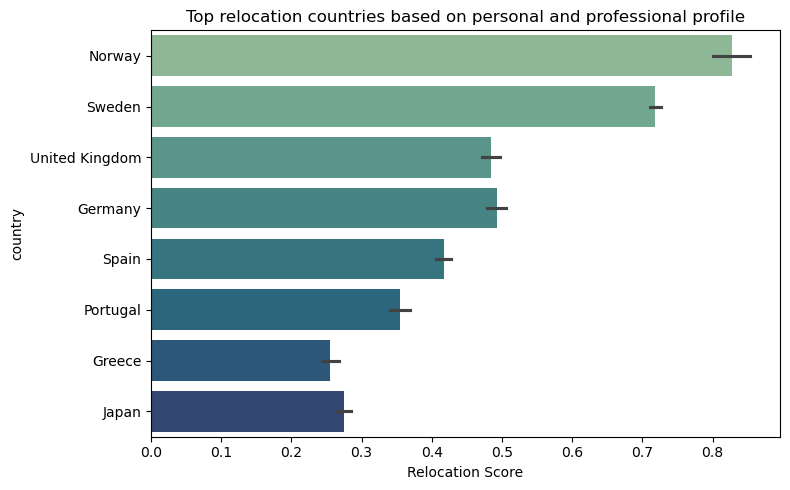

In [11]:
from sklearn.preprocessing import MinMaxScaler

# 1. Merge economic data with contextual scores
df = merged_df.copy()
df = df.merge(context_df, on="country", how="inner")

# 2. Invert Gini → higher is better (less inequality)
df["gini_index_inverted"] = 1 - MinMaxScaler().fit_transform(df[["gini_index"]])

# 3. Normalize variables
features_to_normalize = [
    "gdp_per_capita",
    "education_spending_gdp",
    "unemployment",
    "inflation",
    "lgbt_score",
    "maternity_score"
]

scaler = MinMaxScaler()
df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])

# 4. Apply weights
df["relocation_score"] = (
    0.30 * df["gdp_per_capita"] +
    0.20 * df["gini_index_inverted"] +
    0.15 * df["education_spending_gdp"] +
    0.15 * df["lgbt_score"] +
    0.10 * df["maternity_score"] +
    0.05 * (1 - df["unemployment"]) +
    0.05 * (1 - df["inflation"])
)

# 5. Display top ranking
final_ranking = df[["country", "relocation_score"]].sort_values(by="relocation_score", ascending=False)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.barplot(data=final_ranking, x="relocation_score", y="country", hue = "country", palette="crest", legend=False)
plt.title("Top relocation countries based on personal and professional profile")
plt.xlabel("Relocation Score")
plt.tight_layout()
plt.show()